In [ ]:
import os
import shutil
import tempfile

import cv2 as cv
import imageio
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import time
from joblib import Parallel, delayed
from PIL import Image  # noqa
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from scipy.interpolate import splev, splrep
from scipy.signal import savgol_filter, medfilt
from scipy import ndimage
from itertools import product

import seedir as sd
from ball_detection.dataset import YoloDataset
from ball_detection.utils import cv2pil, pil2cv
from einops import rearrange
from IPython.display import Video

## Methods

In [ ]:
def make_homo(imgs, ref_img, s=0.3, n_jobs=1,FLANN_INDEX_KDTREE=1,MIN_MATCH_COUNT = 10,
              trees=5,k=2,n_ratio=0.7,checks = 50,ransacReprojThreshold = 5.0, nskip=0, w1=1, w2=1):
    """
    TODO: Resizeできるようにする。
    img1 = imgs[0]
    """
    def _make_homo(img1, img2):
        
        ### TODO: はいパラを調整できるようにしたほうがいい　≒　引数で渡せるようにする
        sift = cv.SIFT_create()
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = trees)
        search_params = dict(checks = checks)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        ###
        img1 = cv.resize(img1, (0,0), fx=s, fy=s)
        img2 = cv.resize(img2, (0,0), fx=s, fy=s)

        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None) 
        
        matches = flann.knnMatch(des1,des2,k=k)
        good = []
        for m,n in matches:
            if m.distance < n_ratio*n.distance:
                good.append(m)
                
        assert len(good)>MIN_MATCH_COUNT
        
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, ransacReprojThreshold)
        
        S = [[1,1,s ],[ 1,1, s],[ 1/s, 1/s, 1]]
        return H / S
    
    H = Parallel(n_jobs=n_jobs, prefer='threads')(delayed(_make_homo)(ref_img, img2) for img2 in imgs[::nskip+1])
    H = np.asarray(H)
        
    #Smoothing stuf
    new_H = np.zeros((len(imgs), 3, 3))
    for i, j in product(range(3), range(3)):    
        x = range(len(imgs))[::nskip+1]
        y = H[:, i, j]
        assert len(x) == len(y), (len(x), len(y))
        
        if w1 > 1:
            y = medfilt(y, w1)
        if w2 > 1:
            y = savgol_filter(y, w2, 1)

        spl = splrep(x, y)
        x2 = np.linspace(0, len(imgs), len(imgs), endpoint=False)
        y2 = splev(x2, spl)
        new_H[:, i, j] = y2

    return new_H

#PCAで画像を選択してStitch
def make_pano(H, imgs):
    X = H.copy()
    X = rearrange(X, 'N w h -> N (w h)')

    pca = PCA(n_components=1)
    X = pca.fit_transform(X)

    idxs = X.flatten().argsort() # list of indexes sorted by 1st PC
    selected_idxs = np.hstack([idxs[0:-1:400], idxs[-1]])
    
    stitcher = cv.Stitcher_create()
    stitched = stitcher.stitch([imgs[i] for i in selected_idxs])[1]
    
    return cv2pil(stitched)

#ランダムで画像を選択してStitch
def make_pano2(imgs, n):
    selected_idxs = np.random.choice(range(len(imgs)), n)
    
    stitcher = cv.Stitcher_create()
    stitched = stitcher.stitch([imgs[i] for i in selected_idxs])[1]
    
    return cv2pil(stitched)

def make_video(images: list, fps: int, outpath: str = 'video.mp4'):
    """The main def for creating a temporary video out of the 
    PIL Image list passed, according to the FPS passed
    Parameters
    ----------
    image_list : list
        A list of PIL Images in sequential order you want the video to be generated
    fps : int
        The FPS of the video
    """
    with tempfile.TemporaryDirectory() as dirpath:  # Example: '/tmp/tmpacxadh7t'
        n_imgs = len(kick_dataset)
        filenames = [os.path.join(dirpath, f"{i:06d}.png") for i in range(n_imgs)]
        
        par_func = lambda i, f: i.save(f)
        Parallel(n_jobs=-1)(delayed(par_func)(img, fname) for img, fname in tqdm(zip(images, filenames), total=n_imgs))
            
#         file = os.path.join(dirpath, '%6d.png')
#         os.system(f'ffmpeg -i f"{file}" -c:v libx264 -vf "fps={fps}" {outpath}')
        writer = imageio.get_writer(outpath, fps=fps)
                     
        for fname in tqdm(filenames, total=n_imgs):
            writer.append_data(imageio.imread(fname))
        writer.close()

    print(f"Find your images and video at {outpath}")

def calc_error(kick_dataset,Hp):
    annot_df = pd.concat([annot for im, annot in kick_dataset])
    W, H = kick_dataset[0][0].size

    _KP1 = annot_df[annot_df.label==1].drop(['label', 'width', 'height'], axis=1).values * np.asarray([W, H])
    _KP2 = annot_df[annot_df.label==2].drop(['label', 'width', 'height'], axis=1).values * np.asarray([W, H])
    _KP3 = annot_df[annot_df.label==3].drop(['label', 'width', 'height'], axis=1).values * np.asarray([W, H])

    KP1 = np.hstack((_KP1, np.ones((len(Hp), 1)))) 
    KP2 = np.hstack((_KP2, np.ones((len(Hp), 1))))
    KP3 = np.hstack((_KP3, np.ones((len(Hp), 1))))

    KP1 = rearrange(KP1, 'N dim -> N dim 1')
    KP2 = rearrange(KP2, 'N dim -> N dim 1')
    KP3 = rearrange(KP3, 'N dim -> N dim 1')

    FP1 = (Hp @ KP1 / (Hp @ KP1)[:, 2:, :])[:, :2].squeeze()
    FP2 = (Hp @ KP2 / (Hp @ KP2)[:, 2:, :])[:, :2].squeeze()
    FP3 = (Hp @ KP3 / (Hp @ KP3)[:, 2:, :])[:, :2].squeeze()

    FP = np.mean([FP1,FP2,FP3],axis=0)
    l1 = np.linalg.norm(np.diff(_KP1, axis=0), axis=1)
    l2 = np.linalg.norm(np.diff(FP,axis=0), axis=1)
    
    return l1.mean(),l2.mean()

## Hyperparameter Tuning

In [ ]:
kick_dir = '/data/datasets/sample_kick'
kick_dataset = YoloDataset(kick_dir)

imgs = [pil2cv(im) for im, annot in tqdm(kick_dataset)]

  0%|          | 0/1172 [00:00<?, ?it/s]

In [ ]:
backSub1 = cv.createBackgroundSubtractorKNN(dist2Threshold=2000, detectShadows=False)
backSub2 = cv.createBackgroundSubtractorKNN(dist2Threshold=2000, detectShadows=False)

masks1 = [None for _ in range(len(imgs))]
masks2 = [None for _ in range(len(imgs))]
for i, (im1, im2) in enumerate(tqdm(zip(imgs, imgs[::-1]))):
    f1 = backSub1.apply(im1)
    f2 = backSub2.apply(im2)
    
    masks1[i] = f1
    masks2[-i-1] = f2

0it [00:00, ?it/s]

In [ ]:
def binary_filter(img):
    _, img = cv.threshold(img,200,255,cv.THRESH_BINARY)
    img = ndimage.gaussian_filter(img, 4)
    
    _, img = cv.threshold(img,200,255,cv.THRESH_BINARY)
    img = ndimage.gaussian_filter(img, 20)
    
    _, img = cv.threshold(img,1,255,cv.THRESH_BINARY)    
    return img

b_masks = []
for m1, m2 in zip(tqdm(masks1), masks2):
    r=binary_filter(np.mean([m1, m2], axis=0))
    b_masks.append(r)

  0%|          | 0/1172 [00:00<?, ?it/s]

In [ ]:
p_list = []
for im, mask in zip(imgs[::50], b_masks[::50]):
    mask = cv.bitwise_not(mask.astype(np.uint8))    
    res = cv.bitwise_and(im, im, mask=mask)
    p_list.append(res)

In [ ]:
print(len(p_list))
pano = make_pano2(p_list[::-1], len(p_list))

24


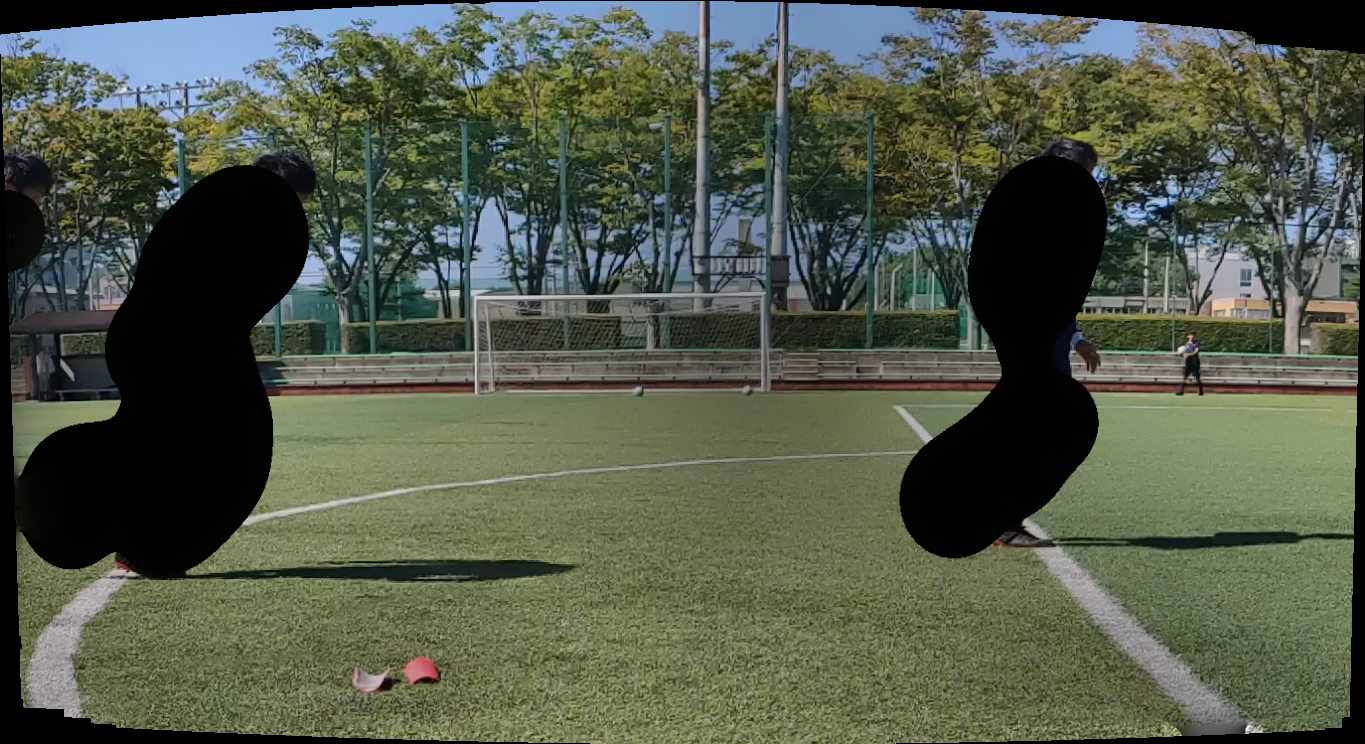

In [ ]:
pano

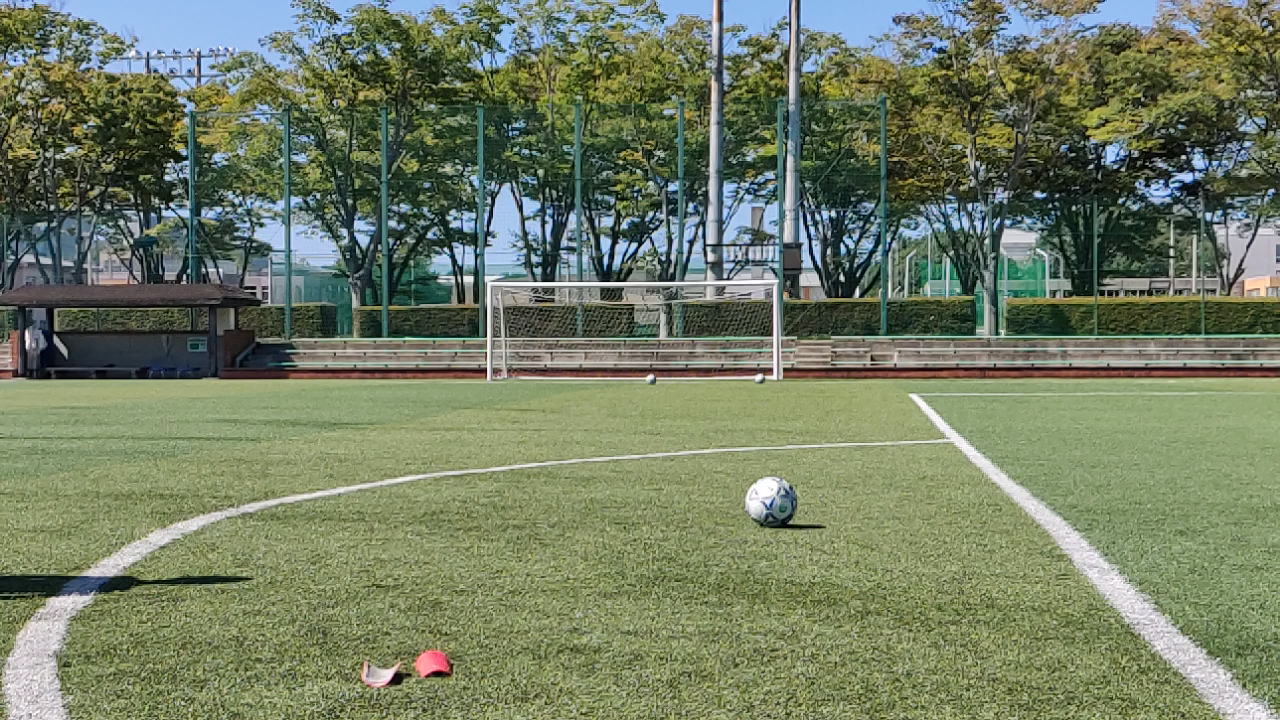

In [ ]:
# Could this be better?

pano = imgs[0].copy()
cv2pil(pano)

CPU times: user 19.3 s, sys: 3.28 s, total: 22.6 s
Wall time: 22.5 s


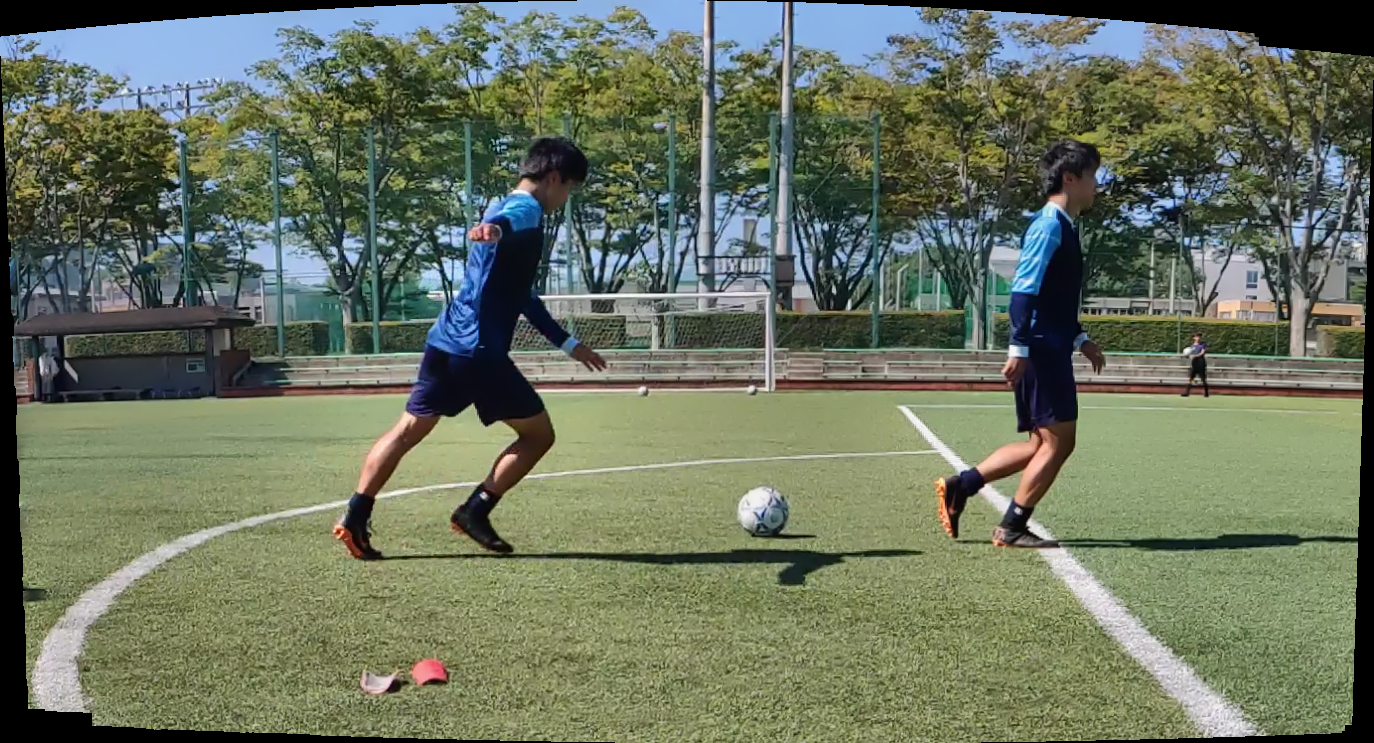

In [ ]:
# %%time
# img_pano = make_pano(imgs, 15)
# img_pano

In [ ]:
def make_panovideo(Hp, background, imgs, outpath):
    transformed = []
    for H, img in zip(Hp, imgs):
        h, w = pil2cv(background).shape[:2]
        im = cv.warpPerspective(img, H, (w, h))
        transformed.append(cv2pil(im))
        
    make_video(transformed, fps=30, outpath=outpath)
    
def objective(trial):
    s = 0.2 # trial.suggest_uniform("s",low=0.1, high=.4)
    
    checks = trial.suggest_int("checks",low=0, high=100,step=10)
    trees =  trial.suggest_int("trees",low=1, high=16,step=1)
    n_ratio = trial.suggest_uniform("n_ratio",low=0.3, high=1.0)
    
    nskip = trial.suggest_int("nskip",low=0, high=10,step=1)
    w1  = trial.suggest_int("w1",low=0, high=30,step=1) * 2 + 1
    w2 = trial.suggest_int("w2",low=0, high=30,step=1) * 2 + 1
    
    k = 2 # trial.suggest_int("k",low=0, high=100,step=1)
    FLANN_INDEX_KDTREE = 1 #trial.suggest_categorical("FLANN_INDEX_KDTREE",[0,1])
    MIN_MATCH_COUNT = 10 # trial.suggest_int("MIN_MATCH_COUNT",low=0, high=100,step=20)
    ransacReprojThreshold = 3 # trial.suggest_int("ransacReprojThreshold",low=1, high=10,step=1)
    

    try:
        start_time = time.time()
        background = pil2cv(pano)[:730, :1360]

        Hp = make_homo(
            imgs, 
            ref_img=background, 
            n_jobs=-1,
            s=s, 
            FLANN_INDEX_KDTREE=FLANN_INDEX_KDTREE,
            MIN_MATCH_COUNT=MIN_MATCH_COUNT,
            trees=trees,
            k=k,
            n_ratio=n_ratio,
            checks=checks,
            ransacReprojThreshold = ransacReprojThreshold,
            w1=w1,
            w2=w2,
            nskip=nskip,
        )

        error = calc_error(kick_dataset,Hp)[1]
        total_time = time.time() - start_time
        
        if not trial.number % 100:
            make_panovideo(Hp, background, imgs, outpath=f'/data/outputs/video_optimization/result_{trial.number}_{error}_{total_time}.mp4')
        return error, total_time
    
    except AssertionError:
        return np.inf, np.inf
    
study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=10000)

[I 2021-06-19 13:11:18,930] A new study created in memory with name: no-name-9f1bfad6-ba92-49a0-a1ac-7e23ea261a1b
[I 2021-06-19 13:11:20,333] Trial 0 finished with values: [inf, inf] and parameters: {'checks': 50, 'trees': 4, 'n_ratio': 0.5493744951139398, 'nskip': 1, 'w1': 3, 'w2': 7}. 
[I 2021-06-19 13:11:23,424] Trial 1 finished with values: [0.3024636316575077, 3.0627920627593994] and parameters: {'checks': 60, 'trees': 13, 'n_ratio': 0.6415492259649922, 'nskip': 6, 'w1': 8, 'w2': 10}. 
[I 2021-06-19 13:11:26,692] Trial 2 finished with values: [0.2894340371876532, 3.265610933303833] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.769694128249329, 'nskip': 8, 'w1': 7, 'w2': 11}. 
[I 2021-06-19 13:11:29,700] Trial 3 finished with values: [0.25841892933264554, 3.0061447620391846] and parameters: {'checks': 60, 'trees': 7, 'n_ratio': 0.7268184875848873, 'nskip': 6, 'w1': 13, 'w2': 26}. 
[I 2021-06-19 13:11:34,529] Trial 4 finished with values: [0.29443720007840085, 4.8272604942

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 13:17:59,440] Trial 100 finished with values: [0.33428948179337326, 2.7330539226531982] and parameters: {'checks': 70, 'trees': 9, 'n_ratio': 0.7815688639630782, 'nskip': 10, 'w1': 9, 'w2': 2}. 


Find your images and video at /data/outputs/video_optimization/result_100_0.33428948179337326_2.7330539226531982.mp4


[I 2021-06-19 13:18:02,205] Trial 101 finished with values: [0.2961850556455237, 2.762049674987793] and parameters: {'checks': 70, 'trees': 13, 'n_ratio': 0.7815688639630782, 'nskip': 10, 'w1': 23, 'w2': 2}. 
[I 2021-06-19 13:18:04,918] Trial 102 finished with values: [0.23987808795147356, 2.7103817462921143] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.6314256997385901, 'nskip': 10, 'w1': 14, 'w2': 24}. 
[I 2021-06-19 13:18:07,974] Trial 103 finished with values: [0.27542716293718095, 3.0536813735961914] and parameters: {'checks': 60, 'trees': 16, 'n_ratio': 0.9867075203420317, 'nskip': 10, 'w1': 8, 'w2': 12}. 
[I 2021-06-19 13:18:10,931] Trial 104 finished with values: [0.26261769138258034, 2.9547250270843506] and parameters: {'checks': 50, 'trees': 13, 'n_ratio': 0.8418291686792274, 'nskip': 8, 'w1': 10, 'w2': 20}. 
[I 2021-06-19 13:18:13,634] Trial 105 finished with values: [0.2533261855600841, 2.7010090351104736] and parameters: {'checks': 50, 'trees': 4, 'n_ratio': 0.6

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 13:24:19,285] Trial 200 finished with values: [0.2585677973946056, 2.604844570159912] and parameters: {'checks': 20, 'trees': 14, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 10, 'w2': 16}. 


Find your images and video at /data/outputs/video_optimization/result_200_0.2585677973946056_2.604844570159912.mp4


[I 2021-06-19 13:24:22,038] Trial 201 finished with values: [0.2354106355995252, 2.750493288040161] and parameters: {'checks': 10, 'trees': 8, 'n_ratio': 0.7735969047093239, 'nskip': 10, 'w1': 20, 'w2': 23}. 
[I 2021-06-19 13:24:31,214] Trial 202 finished with values: [0.37673781735248857, 9.172967195510864] and parameters: {'checks': 70, 'trees': 1, 'n_ratio': 0.7815688639630782, 'nskip': 0, 'w1': 10, 'w2': 6}. 
[I 2021-06-19 13:24:34,047] Trial 203 finished with values: [0.2833827830053687, 2.8307886123657227] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.7735969047093239, 'nskip': 8, 'w1': 14, 'w2': 14}. 
[I 2021-06-19 13:24:34,378] Trial 204 finished with values: [inf, inf] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.4716382660115883, 'nskip': 8, 'w1': 14, 'w2': 11}. 
[I 2021-06-19 13:24:37,094] Trial 205 finished with values: [0.23776913134373137, 2.7118396759033203] and parameters: {'checks': 60, 'trees': 1, 'n_ratio': 0.865458317883941, 'nskip': 9, 'w1': 15

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 13:30:08,527] Trial 300 finished with values: [0.2950917350392898, 2.609224557876587] and parameters: {'checks': 50, 'trees': 1, 'n_ratio': 0.6980097073710616, 'nskip': 10, 'w1': 18, 'w2': 6}. 


Find your images and video at /data/outputs/video_optimization/result_300_0.2950917350392898_2.609224557876587.mp4


[I 2021-06-19 13:30:11,319] Trial 301 finished with values: [0.23495339608039625, 2.789083242416382] and parameters: {'checks': 20, 'trees': 10, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 14, 'w2': 26}. 
[I 2021-06-19 13:30:13,893] Trial 302 finished with values: [0.23305411050336777, 2.5712265968322754] and parameters: {'checks': 50, 'trees': 1, 'n_ratio': 0.8047024443354969, 'nskip': 10, 'w1': 22, 'w2': 26}. 
[I 2021-06-19 13:30:16,651] Trial 303 finished with values: [0.22775824097561426, 2.755613088607788] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 23, 'w2': 27}. 
[I 2021-06-19 13:30:19,281] Trial 304 finished with values: [0.23957306843037715, 2.6268246173858643] and parameters: {'checks': 20, 'trees': 10, 'n_ratio': 0.8809483655485739, 'nskip': 10, 'w1': 13, 'w2': 26}. 
[I 2021-06-19 13:30:22,709] Trial 305 finished with values: [0.3172217520114126, 3.425940990447998] and parameters: {'checks': 80, 'trees': 9, 'n_ratio': 0.

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 13:35:41,944] Trial 400 finished with values: [0.23842730095835826, 2.619511127471924] and parameters: {'checks': 20, 'trees': 11, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 7, 'w2': 24}. 


Find your images and video at /data/outputs/video_optimization/result_400_0.23842730095835826_2.619511127471924.mp4


[I 2021-06-19 13:35:42,413] Trial 401 finished with values: [inf, inf] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.5898679191845584, 'nskip': 10, 'w1': 23, 'w2': 27}. 
[I 2021-06-19 13:35:45,779] Trial 402 finished with values: [0.2671666855965335, 3.3584647178649902] and parameters: {'checks': 70, 'trees': 9, 'n_ratio': 0.865458317883941, 'nskip': 5, 'w1': 30, 'w2': 26}. 
[I 2021-06-19 13:35:48,514] Trial 403 finished with values: [0.2414906203515707, 2.7326323986053467] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.7815688639630782, 'nskip': 10, 'w1': 8, 'w2': 23}. 
[I 2021-06-19 13:35:51,122] Trial 404 finished with values: [0.2302808394070856, 2.6052958965301514] and parameters: {'checks': 20, 'trees': 7, 'n_ratio': 0.7039382016603601, 'nskip': 10, 'w1': 30, 'w2': 26}. 
[I 2021-06-19 13:35:53,735] Trial 405 finished with values: [0.2950707956685212, 2.610405445098877] and parameters: {'checks': 30, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 13:46:01,376] Trial 600 finished with values: [0.230331037113997, 2.5777411460876465] and parameters: {'checks': 100, 'trees': 1, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 30, 'w2': 25}. 


Find your images and video at /data/outputs/video_optimization/result_600_0.230331037113997_2.5777411460876465.mp4


[I 2021-06-19 13:46:04,016] Trial 601 finished with values: [0.25171465396195325, 2.6350862979888916] and parameters: {'checks': 10, 'trees': 15, 'n_ratio': 0.8047024443354969, 'nskip': 10, 'w1': 23, 'w2': 17}. 
[I 2021-06-19 13:46:06,745] Trial 602 finished with values: [0.23069195722870742, 2.7266316413879395] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.775837870117549, 'nskip': 10, 'w1': 23, 'w2': 25}. 
[I 2021-06-19 13:46:09,357] Trial 603 finished with values: [0.3170666275134329, 2.608677387237549] and parameters: {'checks': 20, 'trees': 12, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 23, 'w2': 1}. 
[I 2021-06-19 13:46:12,018] Trial 604 finished with values: [0.2478426897352089, 2.6584529876708984] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.7044121314824888, 'nskip': 8, 'w1': 10, 'w2': 24}. 
[I 2021-06-19 13:46:14,660] Trial 605 finished with values: [0.24292844211795978, 2.639092445373535] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.704

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 13:51:35,936] Trial 700 finished with values: [0.2316080884003218, 2.6115646362304688] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 30, 'w2': 27}. 


Find your images and video at /data/outputs/video_optimization/result_700_0.2316080884003218_2.6115646362304688.mp4


[I 2021-06-19 13:51:38,646] Trial 701 finished with values: [0.26518690271646983, 2.7064642906188965] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.6314256997385901, 'nskip': 10, 'w1': 30, 'w2': 16}. 
[I 2021-06-19 13:51:41,247] Trial 702 finished with values: [0.2294720125944249, 2.5974600315093994] and parameters: {'checks': 60, 'trees': 4, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 26, 'w2': 26}. 
[I 2021-06-19 13:51:43,856] Trial 703 finished with values: [0.23082515253928565, 2.6058120727539062] and parameters: {'checks': 90, 'trees': 3, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 23, 'w2': 26}. 
[I 2021-06-19 13:51:46,530] Trial 704 finished with values: [0.23567318554145603, 2.6710093021392822] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.7039382016603601, 'nskip': 10, 'w1': 15, 'w2': 26}. 
[I 2021-06-19 13:51:49,094] Trial 705 finished with values: [0.23848989922384345, 2.561077117919922] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 13:57:11,869] Trial 800 finished with values: [0.23033191309448656, 2.896357536315918] and parameters: {'checks': 100, 'trees': 9, 'n_ratio': 0.8794302864582317, 'nskip': 10, 'w1': 26, 'w2': 26}. 


Find your images and video at /data/outputs/video_optimization/result_800_0.23033191309448656_2.896357536315918.mp4


[I 2021-06-19 13:57:14,452] Trial 801 finished with values: [0.2317246597775834, 2.57863712310791] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 30, 'w2': 26}. 
[I 2021-06-19 13:57:15,052] Trial 802 finished with values: [inf, inf] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.603627004462215, 'nskip': 6, 'w1': 24, 'w2': 23}. 
[I 2021-06-19 13:57:17,841] Trial 803 finished with values: [0.23309922480985795, 2.7836506366729736] and parameters: {'checks': 70, 'trees': 1, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 23, 'w2': 27}. 
[I 2021-06-19 13:57:20,454] Trial 804 finished with values: [0.23125016921849867, 2.610201358795166] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 23, 'w2': 25}. 
[I 2021-06-19 13:57:23,182] Trial 805 finished with values: [0.23231096388446115, 2.7240543365478516] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.775837870117549, 'nskip': 10, 'w1':

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 14:02:32,554] Trial 900 finished with values: [0.23139779113906364, 2.4913175106048584] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 24, 'w2': 26}. 


Find your images and video at /data/outputs/video_optimization/result_900_0.23139779113906364_2.4913175106048584.mp4


[I 2021-06-19 14:02:35,338] Trial 901 finished with values: [0.24629475227265282, 2.77933669090271] and parameters: {'checks': 0, 'trees': 4, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 9, 'w2': 22}. 
[I 2021-06-19 14:02:37,912] Trial 902 finished with values: [0.23111810355891618, 2.5711233615875244] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 24, 'w2': 26}. 
[I 2021-06-19 14:02:40,638] Trial 903 finished with values: [0.22721340145038152, 2.7225732803344727] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 30, 'w2': 26}. 
[I 2021-06-19 14:02:40,938] Trial 904 finished with values: [inf, inf] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.4604766474441694, 'nskip': 10, 'w1': 24, 'w2': 29}. 
[I 2021-06-19 14:02:43,451] Trial 905 finished with values: [0.24084978142639724, 2.5075929164886475] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 14:08:11,201] Trial 1000 finished with values: [0.23216350065587177, 2.656423807144165] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.7044121314824888, 'nskip': 9, 'w1': 24, 'w2': 26}. 


Find your images and video at /data/outputs/video_optimization/result_1000_0.23216350065587177_2.656423807144165.mp4


[I 2021-06-19 14:08:13,982] Trial 1001 finished with values: [0.23955618049815813, 2.7735044956207275] and parameters: {'checks': 10, 'trees': 9, 'n_ratio': 0.6958703823142937, 'nskip': 10, 'w1': 8, 'w2': 26}. 
[I 2021-06-19 14:08:16,594] Trial 1002 finished with values: [0.2440749565216311, 2.6078290939331055] and parameters: {'checks': 30, 'trees': 1, 'n_ratio': 0.629201349454404, 'nskip': 10, 'w1': 1, 'w2': 25}. 
[I 2021-06-19 14:08:19,260] Trial 1003 finished with values: [0.23204116873585828, 2.662393808364868] and parameters: {'checks': 10, 'trees': 7, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 30, 'w2': 26}. 
[I 2021-06-19 14:08:21,827] Trial 1004 finished with values: [0.23101831536944406, 2.5642220973968506] and parameters: {'checks': 50, 'trees': 1, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 30, 'w2': 26}. 
[I 2021-06-19 14:08:24,542] Trial 1005 finished with values: [0.24712770290679736, 2.711765766143799] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 14:13:57,405] Trial 1100 finished with values: [0.26097169333227216, 3.0847458839416504] and parameters: {'checks': 20, 'trees': 7, 'n_ratio': 0.7044121314824888, 'nskip': 6, 'w1': 24, 'w2': 26}. 


Find your images and video at /data/outputs/video_optimization/result_1100_0.26097169333227216_3.0847458839416504.mp4


[I 2021-06-19 14:14:00,030] Trial 1101 finished with values: [0.23518054843199837, 2.619527578353882] and parameters: {'checks': 100, 'trees': 1, 'n_ratio': 0.775837870117549, 'nskip': 10, 'w1': 13, 'w2': 25}. 
[I 2021-06-19 14:14:03,118] Trial 1102 finished with values: [0.24015020299078949, 3.08428955078125] and parameters: {'checks': 50, 'trees': 1, 'n_ratio': 0.9785513605352223, 'nskip': 10, 'w1': 9, 'w2': 23}. 
[I 2021-06-19 14:14:05,690] Trial 1103 finished with values: [0.23801492207749483, 2.568787097930908] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 26, 'w2': 26}. 
[I 2021-06-19 14:14:08,991] Trial 1104 finished with values: [0.27281959569142183, 3.297724962234497] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 5, 'w1': 23, 'w2': 26}. 
[I 2021-06-19 14:14:11,565] Trial 1105 finished with values: [0.24598262137101612, 2.5699312686920166] and parameters: {'checks': 20, 'trees': 12, 'n_ratio': 0

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 14:20:01,018] Trial 1200 finished with values: [0.3162758959088249, 10.070600986480713] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.9186833927715412, 'nskip': 0, 'w1': 22, 'w2': 25}. 


Find your images and video at /data/outputs/video_optimization/result_1200_0.3162758959088249_10.070600986480713.mp4


[I 2021-06-19 14:20:03,788] Trial 1201 finished with values: [0.23173619373665516, 2.7647650241851807] and parameters: {'checks': 10, 'trees': 7, 'n_ratio': 0.7039382016603601, 'nskip': 10, 'w1': 24, 'w2': 26}. 
[I 2021-06-19 14:20:06,403] Trial 1202 finished with values: [0.2292027989303139, 2.611600637435913] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 26, 'w2': 26}. 
[I 2021-06-19 14:20:09,023] Trial 1203 finished with values: [0.2342909615872387, 2.616239547729492] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 12, 'w2': 26}. 
[I 2021-06-19 14:20:11,782] Trial 1204 finished with values: [0.22894727762179587, 2.755631685256958] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 26, 'w2': 26}. 
[I 2021-06-19 14:20:14,288] Trial 1205 finished with values: [0.26879681100132347, 2.5015804767608643] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 14:25:54,891] Trial 1300 finished with values: [0.23210913602722913, 2.6360177993774414] and parameters: {'checks': 20, 'trees': 12, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 19, 'w2': 26}. 


Find your images and video at /data/outputs/video_optimization/result_1300_0.23210913602722913_2.6360177993774414.mp4


[I 2021-06-19 14:25:55,366] Trial 1301 finished with values: [inf, inf] and parameters: {'checks': 20, 'trees': 7, 'n_ratio': 0.5903472324594559, 'nskip': 10, 'w1': 14, 'w2': 26}. 
[I 2021-06-19 14:25:55,776] Trial 1302 finished with values: [inf, inf] and parameters: {'checks': 100, 'trees': 9, 'n_ratio': 0.5574626260748929, 'nskip': 10, 'w1': 20, 'w2': 26}. 
[I 2021-06-19 14:25:58,797] Trial 1303 finished with values: [0.2491115339565452, 3.0070574283599854] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 7, 'w1': 30, 'w2': 26}. 
[I 2021-06-19 14:26:01,393] Trial 1304 finished with values: [0.23075192513040685, 2.591740131378174] and parameters: {'checks': 10, 'trees': 15, 'n_ratio': 0.603627004462215, 'nskip': 10, 'w1': 23, 'w2': 25}. 
[I 2021-06-19 14:26:04,163] Trial 1305 finished with values: [0.2327540817994235, 2.7664735317230225] and parameters: {'checks': 80, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 19, 'w2': 26}. 
[I 20

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 14:31:45,158] Trial 1400 finished with values: [0.23590549322115892, 2.565371513366699] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.8047024443354969, 'nskip': 10, 'w1': 13, 'w2': 26}. 


Find your images and video at /data/outputs/video_optimization/result_1400_0.23590549322115892_2.565371513366699.mp4


[I 2021-06-19 14:31:47,773] Trial 1401 finished with values: [0.23304219142542293, 2.610302448272705] and parameters: {'checks': 10, 'trees': 5, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 30, 'w2': 24}. 
[I 2021-06-19 14:31:50,494] Trial 1402 finished with values: [0.23962446283577496, 2.7165706157684326] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 9, 'w2': 25}. 
[I 2021-06-19 14:31:50,665] Trial 1403 finished with values: [inf, inf] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.3708208182180225, 'nskip': 10, 'w1': 8, 'w2': 25}. 
[I 2021-06-19 14:31:53,297] Trial 1404 finished with values: [0.23304569080026585, 2.6237287521362305] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 30, 'w2': 25}. 
[I 2021-06-19 14:31:55,990] Trial 1405 finished with values: [0.3656336579664762, 2.6880762577056885] and parameters: {'checks': 20, 'trees': 5, 'n_ratio': 0.6415492259649922, 'nskip': 1

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 14:37:19,838] Trial 1500 finished with values: [0.22805980171101312, 2.5998706817626953] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 30, 'w2': 26}. 


Find your images and video at /data/outputs/video_optimization/result_1500_0.22805980171101312_2.5998706817626953.mp4


[I 2021-06-19 14:37:22,601] Trial 1501 finished with values: [0.2365705307771447, 2.756596088409424] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 23, 'w2': 26}. 
[I 2021-06-19 14:37:25,134] Trial 1502 finished with values: [0.25797216882627827, 2.528709650039673] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.603627004462215, 'nskip': 10, 'w1': 8, 'w2': 18}. 
[I 2021-06-19 14:37:27,806] Trial 1503 finished with values: [0.24018997857824087, 2.668318033218384] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 9, 'w2': 26}. 
[I 2021-06-19 14:37:30,348] Trial 1504 finished with values: [0.2660057469026007, 2.53756046295166] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 30, 'w2': 14}. 
[I 2021-06-19 14:37:33,042] Trial 1505 finished with values: [0.27819941792036657, 2.6898181438446045] and parameters: {'checks': 20, 'trees': 12, 'n_ratio': 0.70

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 14:43:05,129] Trial 1600 finished with values: [0.23291067173418303, 2.5636165142059326] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 20, 'w2': 25}. 


Find your images and video at /data/outputs/video_optimization/result_1600_0.23291067173418303_2.5636165142059326.mp4


[I 2021-06-19 14:43:07,866] Trial 1601 finished with values: [0.23512360958202913, 2.7307960987091064] and parameters: {'checks': 10, 'trees': 1, 'n_ratio': 0.7044121314824888, 'nskip': 10, 'w1': 26, 'w2': 23}. 
[I 2021-06-19 14:43:11,360] Trial 1602 finished with values: [0.296959067917415, 3.489680528640747] and parameters: {'checks': 20, 'trees': 8, 'n_ratio': 0.8047024443354969, 'nskip': 4, 'w1': 28, 'w2': 15}. 
[I 2021-06-19 14:43:14,446] Trial 1603 finished with values: [0.23329139131946028, 3.0806221961975098] and parameters: {'checks': 20, 'trees': 9, 'n_ratio': 0.9731348683332322, 'nskip': 10, 'w1': 30, 'w2': 25}. 
[I 2021-06-19 14:43:17,130] Trial 1604 finished with values: [0.23054502639462335, 2.680304527282715] and parameters: {'checks': 20, 'trees': 14, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 30, 'w2': 25}. 
[I 2021-06-19 14:43:26,315] Trial 1605 finished with values: [0.31806927196646967, 9.18000340461731] and parameters: {'checks': 10, 'trees': 4, 'n_ratio': 0

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 0/1172 [00:00<?, ?it/s]

[I 2021-06-19 14:49:05,638] Trial 1700 finished with values: [0.23102390922199972, 2.615262269973755] and parameters: {'checks': 20, 'trees': 15, 'n_ratio': 0.7492482924832433, 'nskip': 10, 'w1': 30, 'w2': 26}. 


Find your images and video at /data/outputs/video_optimization/result_1700_0.23102390922199972_2.615262269973755.mp4


[I 2021-06-19 14:49:08,229] Trial 1701 finished with values: [0.23976122385900228, 2.5841400623321533] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.629201349454404, 'nskip': 10, 'w1': 30, 'w2': 25}. 
[I 2021-06-19 14:49:10,846] Trial 1702 finished with values: [0.23613894011803382, 2.612887144088745] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.8978048007787602, 'nskip': 10, 'w1': 23, 'w2': 26}. 
[I 2021-06-19 14:49:16,498] Trial 1703 finished with values: [0.31004958873295313, 5.64692234992981] and parameters: {'checks': 20, 'trees': 1, 'n_ratio': 0.775837870117549, 'nskip': 1, 'w1': 23, 'w2': 26}. 


In [ ]:
# study.best_params,study.best_value,
df = study.trials_dataframe()
df.to_csv('optuna_results.csv') # 一番良いスコア